In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin
import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier



##Importing so we can run calculations on data

/Users/darren.wong/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
##importing data into a dataframe from pandas
fraud_data = pd.read_csv('Documents/Python Practice/Case Study 2023 - Dataset - Klarna Overnight Case Study Data (1).csv')
print(fraud_data.columns)

#convert to categorical data and ordinal categorical data

Index(['transaction_id', 'time_of_purchase', 'purchase_amount', 'customer_id',
       'fname', 'lname', 'age', 'addr_city', 'email', 'has_paid_before',
       'annual_salary', 'type_of_goods', 'delivery_city', 'ip_country',
       'is_fraud'],
      dtype='object')


In [3]:
fraud_data.info()
#no null values, data is good - only missing IP country  - need to allocate 'unknown'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10277 entries, 0 to 10276
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   transaction_id    10277 non-null  int64 
 1   time_of_purchase  10277 non-null  object
 2   purchase_amount   10277 non-null  int64 
 3   customer_id       10277 non-null  int64 
 4   fname             10277 non-null  object
 5   lname             10277 non-null  object
 6   age               10277 non-null  int64 
 7   addr_city         10277 non-null  object
 8   email             10277 non-null  object
 9   has_paid_before   10277 non-null  object
 10  annual_salary     10277 non-null  object
 11  type_of_goods     10277 non-null  object
 12  delivery_city     10277 non-null  object
 13  ip_country        9673 non-null   object
 14  is_fraud          10277 non-null  object
dtypes: int64(4), object(11)
memory usage: 1.2+ MB


In [4]:
#process to numerical data for is_fraud and has_paid
le = LabelEncoder()
fraud_data['is_fraud_enc'] = le.fit_transform(fraud_data['is_fraud'])
fraud_data['has_paid_before_enc'] = le.fit_transform(fraud_data['has_paid_before'])

#create dummy variables for ip_country and type_of_goods for machine learning
ip_country = pd.get_dummies(fraud_data['ip_country'])
type_of_goods = pd.get_dummies(fraud_data['type_of_goods'])
addr_city = pd.get_dummies(fraud_data['addr_city'])
delivery_city = pd.get_dummies(fraud_data['delivery_city'])

fraud_data = pd.concat([fraud_data, ip_country], axis=1)
fraud_data = pd.concat([fraud_data, type_of_goods], axis=1)
fraud_data = pd.concat([fraud_data, addr_city], axis=1)
fraud_data = pd.concat([fraud_data, delivery_city], axis=1)

In [5]:
print(ip_country)

          DK     FI     NO     SE     UK     US
0      False  False  False   True  False  False
1      False  False  False   True  False  False
2      False  False  False   True  False  False
3      False  False  False   True  False  False
4      False   True  False  False  False  False
...      ...    ...    ...    ...    ...    ...
10272  False  False  False  False  False  False
10273  False  False  False  False  False  False
10274  False  False  False  False  False  False
10275  False  False  False  False  False  False
10276  False  False  False  False  False  False

[10277 rows x 6 columns]


In [6]:
fraud_data['annual_salary'] = fraud_data['annual_salary'].replace('-', 0)


fraud_dtypes = {'customer_id': 'category',
                   'age': 'category', #ordinal category
                   'addr_city': 'category',
                   'has_paid_before': 'category', #convert to bool
                   'annual_salary': 'int',#ordinal category
                   'type_of_goods': 'category',
                   'delivery_city': 'category',
                   'ip_country': 'category',
                   'is_fraud': 'category' #convert to bool
                  }

fraud_data = fraud_data.astype(fraud_dtypes)


In [7]:
fraud_data['time_of_purchase'] = pd.to_timedelta(fraud_data['time_of_purchase'])
print(fraud_data['time_of_purchase'].dt.components['hours'])

0        16
1        14
2        12
3        15
4        16
         ..
10272    21
10273    21
10274    21
10275    21
10276    21
Name: hours, Length: 10277, dtype: int64


In [8]:
fraud_data['annual_salary'].dtype

dtype('int64')

In [9]:
# Using qcut() to group salaries (10? or less) ... and ages? use qcut for quantiles rather than cut with defined ranges

"""group_names = ['0-125K','125K-500K','500K+']
demographics['income_group'] = pd.qcut(demographics['household_income'], q = 3, labels = group_names)
# Print income_group column
demographics[['income_group','household_income']]"""

# Using cut() - create category ranges and names .. as no salaries of 0.. min is 1000
ranges = [-1,1,75000,150000,300000,np.inf]
group_names = ['0','1-75k','75-150K','150K-300K','300K+']
# Create income group column
fraud_data['salary_bracket'] = pd.cut(fraud_data['annual_salary'], bins=ranges,labels=group_names)
# Do the same for purchase_amount ? 

In [10]:

salary_bracket = pd.get_dummies(fraud_data['salary_bracket'])
fraud_data = pd.concat([fraud_data, salary_bracket], axis=1)

In [11]:
print(fraud_data.columns)

Index(['transaction_id', 'time_of_purchase', 'purchase_amount', 'customer_id',
       'fname', 'lname', 'age', 'addr_city', 'email', 'has_paid_before',
       'annual_salary', 'type_of_goods', 'delivery_city', 'ip_country',
       'is_fraud', 'is_fraud_enc', 'has_paid_before_enc', 'DK', 'FI', 'NO',
       'SE', 'UK', 'US', 'Books', 'Clothing', 'Dating', 'Electronics', 'Food',
       'Tickets', 'Goteborg', 'Knivsta', 'Linköping', 'Lund', 'Malmö',
       'Nykvarn', 'Stockholm', 'Uppsala', 'Västerås', 'Örebro', 'Goteborg',
       'Knivsta', 'Linköping', 'Lund', 'Malmö', 'Nykvarn', 'Stockholm',
       'Uppsala', 'Västerås', 'Örebro', 'salary_bracket', '0', '1-75k',
       '75-150K', '150K-300K', '300K+'],
      dtype='object')


In [12]:
print(fraud_data.head())
pca = PCA()

columns_to_drop = ['transaction_id', 'time_of_purchase', 'customer_id', 'fname', 'lname', 'addr_city', 'email', 'has_paid_before', 'type_of_goods', 'delivery_city', 'ip_country', 'is_fraud', 'is_fraud_enc', 'salary_bracket', 'annual_salary']
X = fraud_data.drop(columns_to_drop, axis=1)
y = fraud_data['is_fraud_enc']

   transaction_id time_of_purchase  purchase_amount customer_id   fname  \
0         2001563  0 days 16:52:11            15249        3941  Agneta   
1         1997663  0 days 14:20:45             9334      122158  Agneta   
2         2013263  0 days 12:26:00             8744       25977  Agneta   
3         2009363  0 days 15:13:01             6779       31238  Agneta   
4         1988563  0 days 16:08:04             4963       37499  Agneta   

        lname age  addr_city                         email has_paid_before  \
0     Jansson  28  Stockholm    agneta.jansson@hotmail.com               t   
1  Gustafsson  73      Malmö   agneta_gustafsson@gmail.com               f   
2    Olofsson  60  Stockholm   agneta.olofsson@hotmail.com               t   
3   Petersson  66  Stockholm  agneta.petersson@hotmail.com               t   
4    Karlsson  36       Lund             agn.karl@yahoo.se               f   

   ...  Stockholm Uppsala Västerås Örebro salary_bracket      0  1-75k  \
0  ...

In [13]:
#machine learning to figure which variables are most correlated to fraudulent orders
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [14]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9662775616083009
[[2924   14]
 [  90   56]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2938
           1       0.80      0.38      0.52       146

    accuracy                           0.97      3084
   macro avg       0.89      0.69      0.75      3084
weighted avg       0.96      0.97      0.96      3084



In [15]:
##scale data to improve accuracy 

steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsClassifier(n_neighbors=2))]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

knn_scaled=pipeline.fit(X_train, y_train)
y_pred = knn_scaled.predict(X_test)
print(knn_scaled.score(X_test, y_test))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9672503242542153
[[2923   15]
 [  86   60]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2938
           1       0.80      0.41      0.54       146

    accuracy                           0.97      3084
   macro avg       0.89      0.70      0.76      3084
weighted avg       0.96      0.97      0.96      3084



In [30]:

steps = [('scaler', StandardScaler()),
         ('Decision Tree', DecisionTreeClassifier())]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

decision_scaled=pipeline.fit(X_train, y_train)
y_pred = decision_scaled.predict(X_test)
print(decision_scaled.score(X_test, y_test))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9649805447470817
[[2894   44]
 [  64   82]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2938
           1       0.65      0.56      0.60       146

    accuracy                           0.96      3084
   macro avg       0.81      0.77      0.79      3084
weighted avg       0.96      0.96      0.96      3084



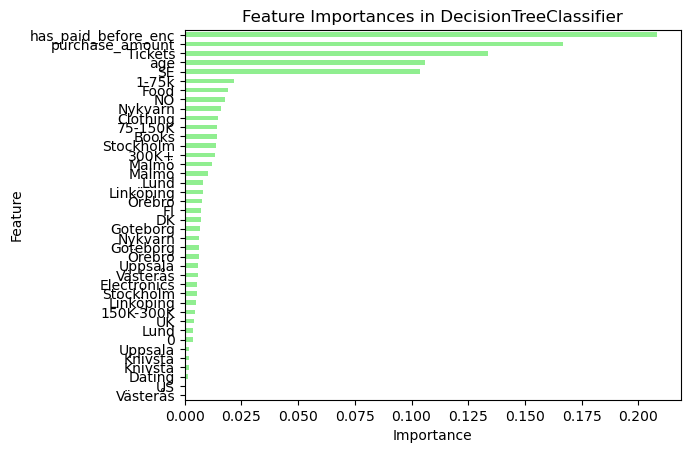

In [33]:
# Create a pd.Series of features importances
importances_dt = pd.Series(decision_scaled.named_steps['Decision Tree'].feature_importances_, index=X.columns)

# Sort importances_
sorted_importances_dt = importances_dt.sort_values()

# Make a horizontal bar plot
sorted_importances_dt.plot(kind='barh', color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in DecisionTreeClassifier')
plt.show()

In [17]:
##scale data to improve accuracy 

#Set up pipeline
steps = [("scaler", StandardScaler()),
         ("logreg", LogisticRegression())]
pipeline = Pipeline(steps)

# Create the parameter space to test
parameters = {"logreg__C": np.linspace(0.001, 1.0, num=20)}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=1)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training data
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)
print(cv.best_score_, "\n", cv.best_params_)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9694165415830224 
 {'logreg__C': 0.47421052631578947}
[[2934   24]
 [  53   73]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2958
           1       0.75      0.58      0.65       126

    accuracy                           0.98      3084
   macro avg       0.87      0.79      0.82      3084
weighted avg       0.97      0.98      0.97      3084



In [26]:
steps = [('scaler', StandardScaler()),
         ('Decision Tree', RandomForestClassifier())]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

decision_scaled=pipeline.fit(X_train, y_train)
y_pred = decision_scaled.predict(X_test)
print(decision_scaled.score(X_test, y_test))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9730869001297017
[[2924   14]
 [  69   77]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2938
           1       0.85      0.53      0.65       146

    accuracy                           0.97      3084
   macro avg       0.91      0.76      0.82      3084
weighted avg       0.97      0.97      0.97      3084



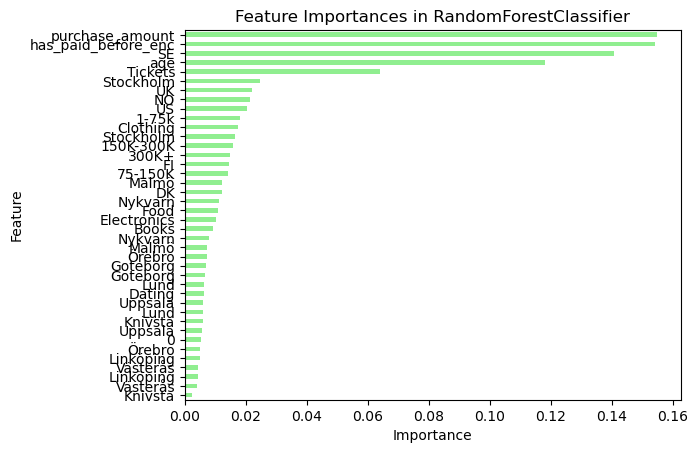

In [29]:
# Create a pd.Series of features importances
importances_rf = pd.Series(decision_scaled.named_steps['Decision Tree'].feature_importances_, index=X.columns)

# Sort importances_
sorted_importances_rf = importances_rf.sort_values()

# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in RandomForestClassifier')
plt.show()

In [19]:
# To test optimum number of nearest neighbours
neighbours = np.arange(1, 12)
train_accuracies = {}
test_accuracies = {}

for neighbour in neighbours:
  
	# Set up a KNN Classifier
	knn = KNeighborsClassifier(n_neighbors=neighbour)
  
	# Fit the model
	knn.fit(X_train, y_train)
  
	# Compute accuracy
	train_accuracies[neighbour] = knn.score(X_train, y_train)
	test_accuracies[neighbour] = knn.score(X_test, y_test)
print(neighbours, '\n', train_accuracies, '\n', test_accuracies)

[ 1  2  3  4  5  6  7  8  9 10 11] 
 {1: 1.0, 2: 0.9790073682747116, 3: 0.9751146948422077, 4: 0.972056165716669, 5: 0.9678854441818434, 6: 0.9653830112609482, 7: 0.9614903378284443, 8: 0.9609342416238009, 9: 0.9596830251633532, 10: 0.956207423884332, 11: 0.955234255526206} 
 {1: 0.9601167315175098, 2: 0.9662775616083009, 3: 0.9591439688715954, 4: 0.9623865110246433, 5: 0.9562256809338522, 6: 0.9539559014267186, 7: 0.9523346303501945, 8: 0.9555771725032426, 9: 0.9539559014267186, 10: 0.9555771725032426, 11: 0.9539559014267186}


In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
knn = KNeighborsClassifier(n_neighbors=2)
cv_scores = cross_val_score(knn, X, y, cv=kf)
print(cv_scores)
print(np.mean(cv_scores))

[0.9713035  0.97081712 0.96934307 0.96155718 0.96934307]
0.9684727863141053


In [21]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
##precision score TP / TP + FP - Hit rate
##recall score TP / TP + FN - Catch rate

[[2924   14]
 [  90   56]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2938
           1       0.80      0.38      0.52       146

    accuracy                           0.97      3084
   macro avg       0.89      0.69      0.75      3084
weighted avg       0.96      0.97      0.96      3084



In [22]:
## Try logistic regression modelling to improve catch rate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predict fraudulent probabilities
y_pred_probs = logreg.predict_proba(X_test)[:, 1]

print(y_pred_probs[:10])

[0.0011995  0.00034605 0.00036281 0.00235041 0.00363298 0.02000937
 0.00185743 0.0002942  0.07138508 0.00130594]


/Users/darren.wong/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


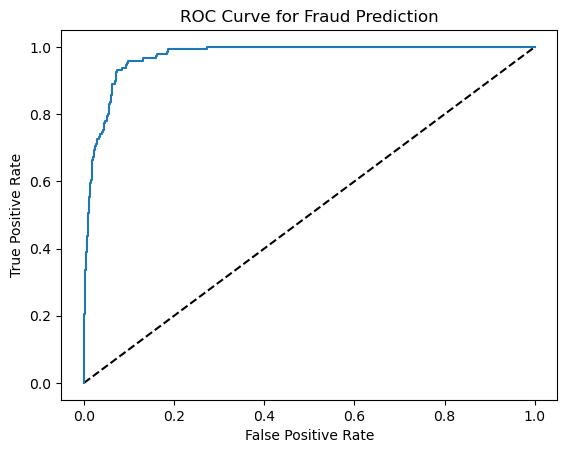

In [23]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fraud Prediction')
plt.show()

In [24]:
# Calculate roc_auc_score
print(roc_auc_score(y_test, y_pred_probs))

# Calculate the confusion matrix
print(confusion_matrix(y_test, y_pred))

# Calculate the classification report
print(classification_report(y_test, y_pred))

0.9730177084401839
[[2924   14]
 [  90   56]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2938
           1       0.80      0.38      0.52       146

    accuracy                           0.97      3084
   macro avg       0.89      0.69      0.75      3084
weighted avg       0.96      0.97      0.96      3084



In [25]:
## Tuning hyper parameters to improve accuracy - changing values of Regularization find optimum level not to over/under fit
#param_grid = {"alpha": np.linspace(0.00001, 1, 20)}
params = {"penalty": ["l1", "l2"],
         "tol": np.linspace(0.0001, 1.0, 50),
         "C": np.linspace(0.1, 1.0, 50),
         "class_weight": ["balanced", {0:0.8, 1:0.2}]}
logreg_cv = RandomizedSearchCV(logreg, params, cv=kf)
logreg_cv.fit(X_train, y_train)
print("Tuned Logistic Regression paramaters: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Best Accuracy Score: {}".format(logreg_cv.best_score_))

/Users/darren.wong/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/darren.wong/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    h

Tuned Logistic Regression paramaters: {'tol': 0.9387816326530612, 'penalty': 'l2', 'class_weight': {0: 0.8, 1: 0.2}, 'C': 0.7612244897959184}
Tuned Logistic Regression Best Accuracy Score: 0.9603784307793719


/Users/darren.wong/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/darren.wong/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
-------------------------------------

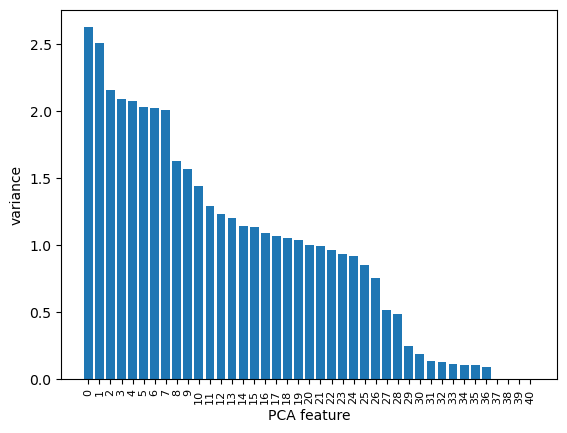

In [64]:
scaler = StandardScaler()
pipeline = make_pipeline(scaler, pca)

columns_to_drop1 = ['transaction_id', 'time_of_purchase', 'customer_id', 'fname', 'lname', 'addr_city', 'email', 'has_paid_before', 'type_of_goods', 'delivery_city', 'ip_country', 'is_fraud', 'salary_bracket', 'annual_salary']
pca_fraud_data = fraud_data.drop(columns_to_drop1, axis=1)

pipeline.fit(pca_fraud_data)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features, rotation=90, fontsize=8)  # Rotate x-axis tick labels by 90 degrees
plt.show()


In [ ]:
classifiers = [('Logistic Regression', lr),
               ('K Nearest Neighbours', knn),
               ('Classification Tree', dt)]

#train test split and standardize data initially before using VC, stratify yes and use hyper parameters from previous i.e. n_neighbors = 2 etc

for clf_name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))

In [ ]:
# Create a votingclassifier of the 3 best models to use on set
vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)

print('Voting Classifier: {.3f}'.format(accuracy_score(y_test, y_pred)))

In [67]:
##subset clothing type of goods
clothing = fraud_data[fraud_data['type_of_goods'] == 'Clothing']
print(clothing.head())

   transaction_id time_of_purchase  purchase_amount customer_id   fname  \
0         2001563  0 days 16:52:11            15249        3941  Agneta   
2         2013263  0 days 12:26:00             8744       25977  Agneta   
5         2032763  0 days 16:20:38             4485       19884  Agneta   
6         1991163  0 days 20:46:27             4275      119430  Agneta   
8         1996363  0 days 11:05:36             3948      113040  Agneta   

      lname age  addr_city                        email has_paid_before  ...  \
0   Jansson  28  Stockholm   agneta.jansson@hotmail.com               t  ...   
2  Olofsson  60  Stockholm  agneta.olofsson@hotmail.com               t  ...   
5   Sjoberg  52  Stockholm   agneta.sjoberg@hotmail.com               t  ...   
6  Eriksson  40  Stockholm             ojr16tfv@live.se               f  ...   
8  Svensson  25   Västerås     agn_svensson@hotmail.com               t  ...   

   Stockholm Uppsala Västerås Örebro salary_bracket      0  1-75k  7

In [ ]:
print(clothing['is_fraud'].describe())

In [ ]:
proportion_fraud_clothing = (clothing[clothing['is_fraud'] == 't'].count()) / (clothing['is_fraud'].count())
print(proportion_fraud_clothing['is_fraud'])

In [ ]:
fraudulent_orders = fraud_data[fraud_data['is_fraud'] == 't']
print(fraudulent_orders.head())


In [ ]:

pivot = fraudulent_orders.pivot_table(index=['type_of_goods', 'has_paid_before', 'delivery_city'], values='purchase_amount', aggfunc='sum')
print(pivot)

In [ ]:
fraud_yes = fraud_data[fraud_data['is_fraud'] == "t"]

In [ ]:
print(fraud_yes.describe())

In [11]:
## fraud_data['amount'] crosstab with categories?

def get_hour(time):
    return datetime.strptime(time, "%H:%M:%S").hour

fraud_yes['time_of_purchase'] = fraud_yes['time_of_purchase'].apply(get_hour)




NameError: name 'fraud_yes' is not defined

In [12]:
print(fraud_yes['time_of_purchase'].value_counts())

NameError: name 'fraud_yes' is not defined

In [13]:


hour_bins = np.arange(0, 25)
fraud_yes.hist(column='time_of_purchase', bins=24, range=(0,24))
sns.histplot(data=fraud_yes, x='time_of_purchase', bins=24)

ax = plt.gca()
# Set the x-axis ticks to be at the hours and labels to be the corresponding hour strings
ax.set_xticks(hour_bins[:])  
ax.set_xticklabels(map(str, hour_bins[:]))  # Convert hour values to strings for labels

# You may also want to add grid, labels, and title
ax.grid(axis='y', alpha=0.75)
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Frequency')
ax.set_title('Time of Purchase')
plt.show()

NameError: name 'fraud_yes' is not defined

In [14]:
#proportions of fraud 
props_type = fraud_data.groupby('is_fraud')['type_of_goods'].value_counts(normalize=True)
props_city = fraud_data.groupby('is_fraud')['delivery_city'].value_counts(normalize=True)



In [15]:
fraud_data['time_of_purchase'] = pd.to_datetime(fraud_data['time_of_purchase'], format='%H:%M:%S').dt.strftime('%H:%M')

TypeError: dtype timedelta64[ns] cannot be converted to datetime64[ns]

In [16]:
print(fraud_data['time_of_purchase'].head())


0   0 days 16:52:11
1   0 days 14:20:45
2   0 days 12:26:00
3   0 days 15:13:01
4   0 days 16:08:04
Name: time_of_purchase, dtype: timedelta64[ns]


<Axes: >

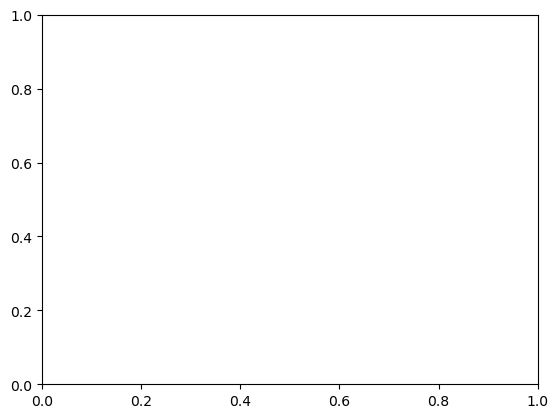

In [17]:
sns.countplot(x='time_of_purchase', data=(fraud_data[fraud_data['is_fraud'] == 't']))